Iteration: 0


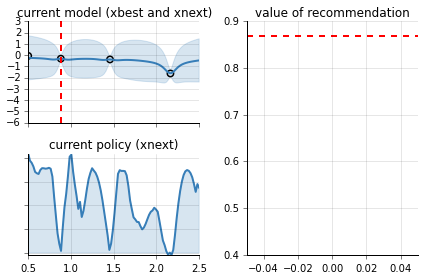

Iteration: 1


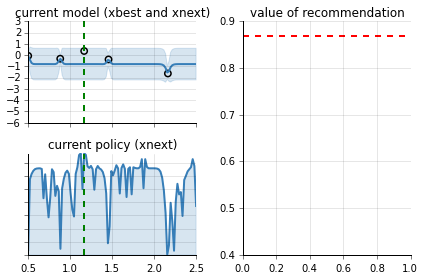

Iteration: 2


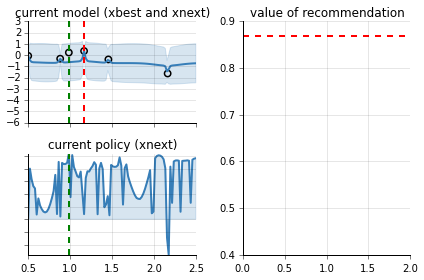

Iteration: 3


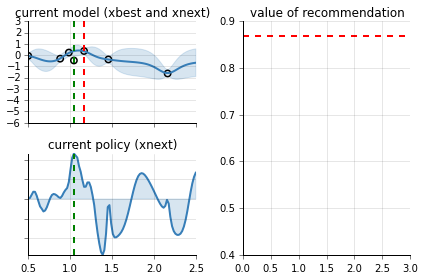

Iteration: 4


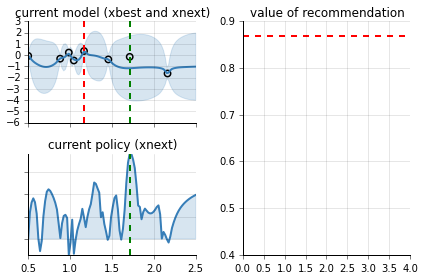

Iteration: 5


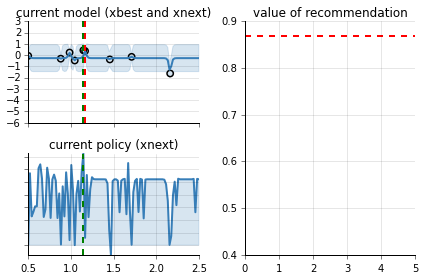

Iteration: 6


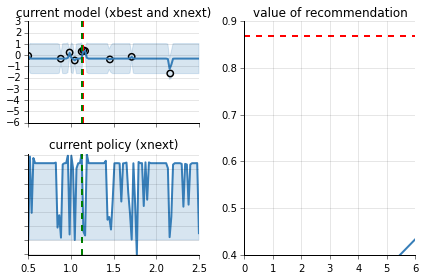

Iteration: 7


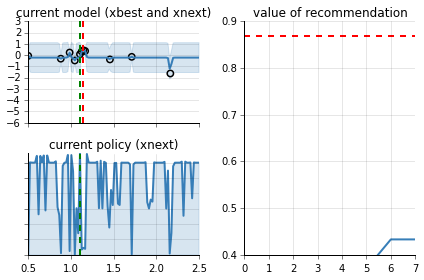

Iteration: 8


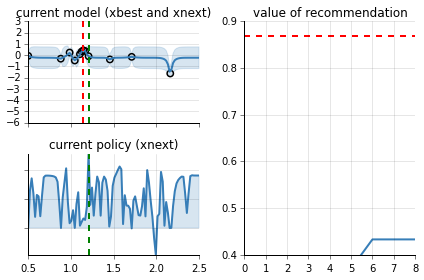

Iteration: 9


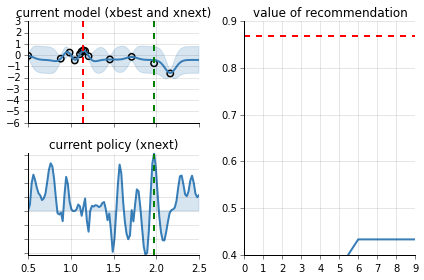

Iteration: 10


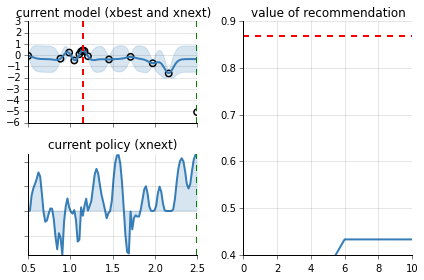

Iteration: 11


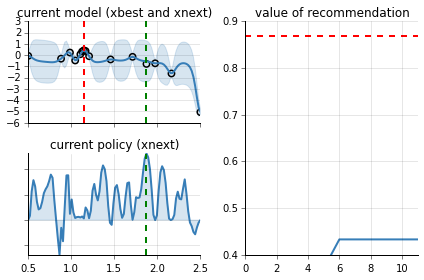

Iteration: 12


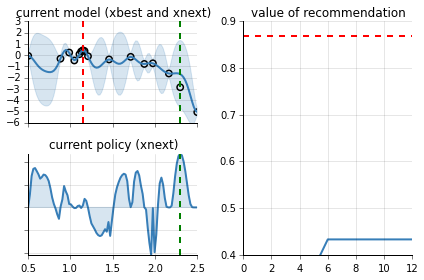

Iteration: 13


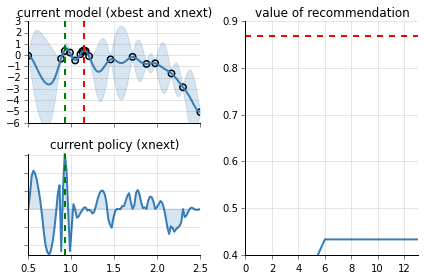

Iteration: 14


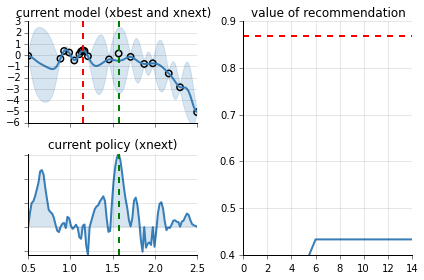

Iteration: 15


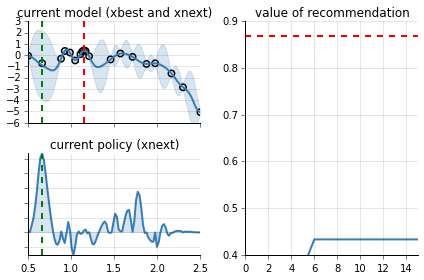

Iteration: 16


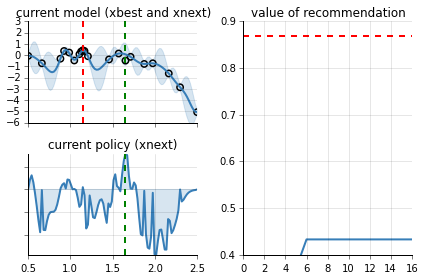

Iteration: 17


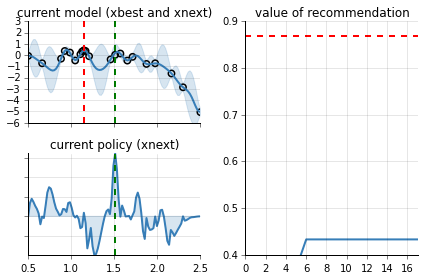

Iteration: 18


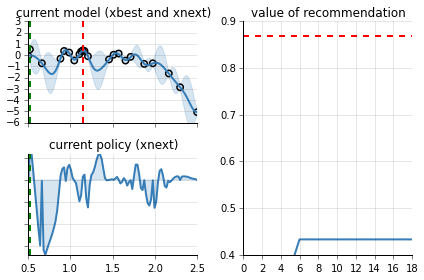

Iteration: 19


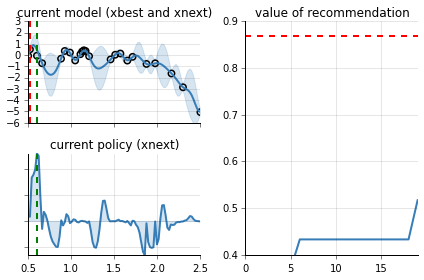

Iteration: 20


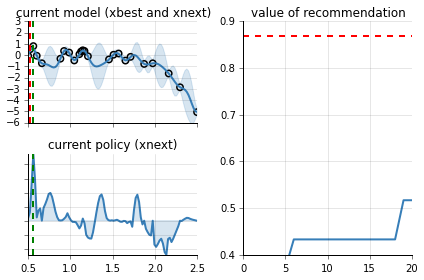

Iteration: 21


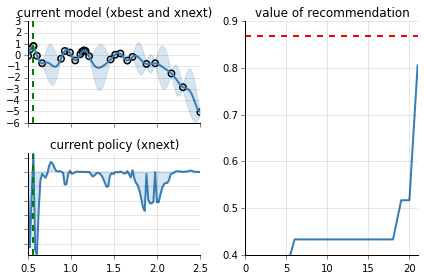

Iteration: 22


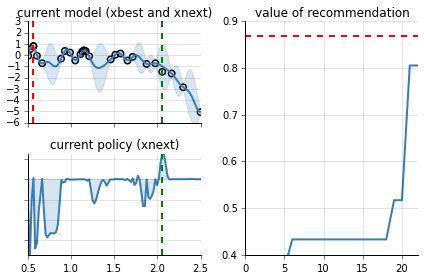

Iteration: 23


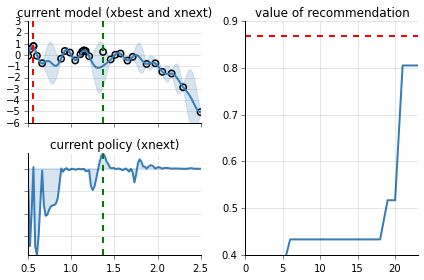

Iteration: 24


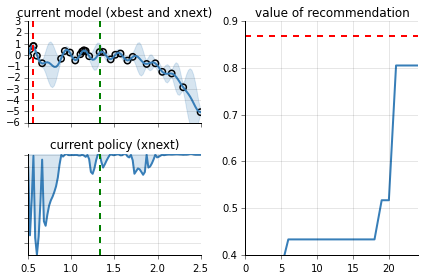

Iteration: 25


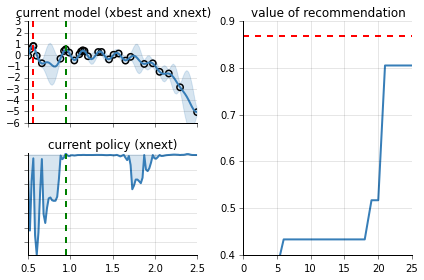

Iteration: 26


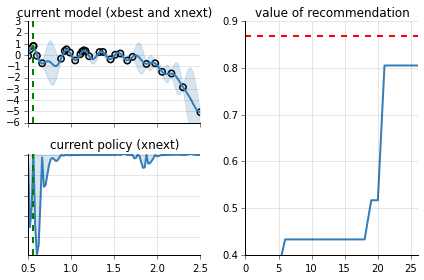

Iteration: 27


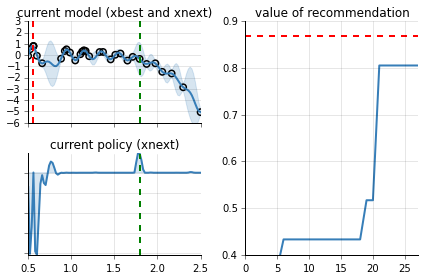

Iteration: 28


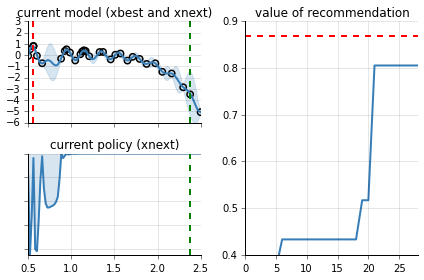

Iteration: 29


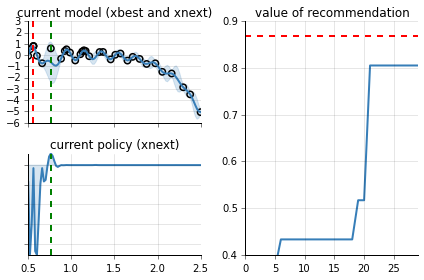

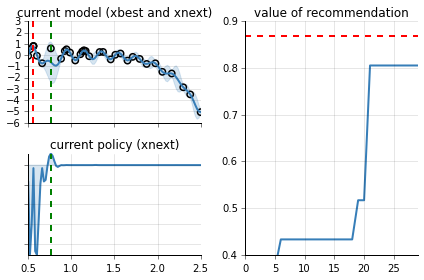

In [3]:
%matplotlib inline

"""
Animated demo showing progress of Bayesian optimization on a simple
(but highly multimodal) one-dimensional function.
"""

from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import reggie as rg
import ezplot as ez

from pybo.bayesopt import IndexPolicy, RecPolicy
from pybo.domains import Grid

__all__ = []


def f(x):
    """
    Test function we'll optimize. This is a 1d, sinusoidal function used by
    Gramacy and Lee in "Cases for the nugget in modeling computer experiments".
    """
    x = float(x)
    return -np.sin(10*np.pi*x) / (2*x) - (x-1)**4


# define the bounds over which we'll optimize, the optimal x for
# comparison, and a sequence of test points
bounds = [0.5, 2.5]
xopt = 0.54856343
fopt = f(xopt)

# create the domain and the policies
domain = Grid(bounds, 100)

# policy choices: PI, EI, UCB, Thompson, PES, IPES
policy_name = 'IPES'

if policy_name == 'PES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': False})
elif policy_name == 'IPES':
    policy = IndexPolicy(domain, 'PES', {'opes': False, 'ipes': True})
else:
    policy = IndexPolicy(domain, policy_name)

recommender = RecPolicy(domain, 'observed')

# get initial data and some test points.
X = list(domain.init())
Y = [f(x_) for x_ in X]
F = []

# initialize the model
model = rg.make_gp(0.01, 1.9, 0.1, 0)

# set the priors and make the model sample over hyperparameters
model.params['like']['sn2'].prior = rg.priors.Uniform(0.005, 0.015)
model.params['kern']['rho'].prior = rg.priors.LogNormal(0, 100)
model.params['kern']['ell'].prior = rg.priors.LogNormal(0, 10)
model.params['mean']['bias'].prior = rg.priors.Normal(0, 20)

# make a meta-model to sample over models; add data
model = rg.MCMC(model, n=20, skip=True)
model.add_data(X, Y)

# grab a figure
fig = ez.figure()

n_iters = 30
for i in range(n_iters):
    print('Iteration: ' + str(i))
    # get the recommendation and the next query
    xbest = recommender(model, X, Y)
    xnext = policy(model, X)
    ynext = f(xnext)

    # evaluate the posterior before updating the model for plotting
    mu, s2 = model.predict(domain.X)

    # record our data and update the model
    X.append(xnext)
    Y.append(ynext)
    F.append(f(xbest))
    model.add_data(xnext, ynext)

    # PLOT EVERYTHING
    fig.clear()
    ax1 = fig.add_subplotspec((2, 2), (0, 0), hidex=True)
    ax2 = fig.add_subplotspec((2, 2), (1, 0), hidey=True, sharex=ax1)
    ax3 = fig.add_subplotspec((2, 2), (0, 1), rowspan=2)

    # plot the posterior and data
    ax1.plot_banded(domain.X.ravel(), mu, 2*np.sqrt(s2))
    ax1.scatter(np.ravel(X), Y)
    ax1.axvline(xbest)
    ax1.axvline(xnext, color='g')
    ax1.set_ylim(-6, 3)
    ax1.set_title('current model (xbest and xnext)')

    # plot the acquisition function
    ax2.plot_banded(domain.X.ravel(), policy._index(domain.X))
    ax2.axvline(xnext, color='g')
    ax2.set_xlim(*bounds)
    ax2.set_title('current policy (xnext)')

    # plot the latent function at recomended points
    ax3.plot(F)
    ax3.axhline(fopt)
    ax3.set_ylim(0.4, 0.9)
    ax3.set_title('value of recommendation')

    # draw
    fig.canvas.draw()
    ez.show(block=False)
